In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time, random
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import make_column_transformer
import sqlite3
from zipfile import ZipFile
import io
import os
import re
from matplotlib.animation import FuncAnimation
from IPython.core.display import HTML

Part 1: Linear Regression

In [3]:
connection = sqlite3.connect("data/images.db")
df = pd.read_sql("""
SELECT file_name, district_name, lon, lat, water_ratio, forest_ratio, agriculture_ratio, developed_ratio
FROM sample INNER JOIN districts ON sample.district_id = districts.district_id LIMIT 400
""", connection) 
train, test = train_test_split(df, random_state=0)
df
test

,file_name,district_name,lon,lat,water_ratio,forest_ratio,agriculture_ratio,developed_ratio
132,area0132.npy,district 06,-87.940213,43.750300,0.0058,0.0266,0.5506,0.2990
309,area0309.npy,district 07,-91.854009,45.352143,0.0002,0.1366,0.8074,0.0401
341,area0341.npy,district 01,-88.294035,42.656175,0.0010,0.3283,0.2029,0.1805
196,area0196.npy,district 06,-89.557249,44.187877,0.0000,0.0836,0.8079,0.0412
246,area0246.npy,district 05,-88.596203,43.159942,0.0002,0.0201,0.6677,0.0921
...,...,...,...,...,...,...,...,...
146,area0146.npy,district 08,-87.869312,44.365150,0.0048,0.0249,0.8343,0.0896
135,area0135.npy,district 06,-87.852985,43.935362,0.0030,0.0463,0.8241,0.0697
390,area0390.npy,district 01,-88.908064,42.562049,0.0000,0.1818,0.6871,0.0763
264,area0264.npy,district 01,-87.842951,42.704875,0.0030,0.0376,0.0423,0.8906


In [11]:
#q1: What are the last 5 rows of the test dataset?
q1=test.tail()
q1

,file_name,district_name,lon,lat,water_ratio,forest_ratio,agriculture_ratio,developed_ratio
146,area0146.npy,district 08,-87.869312,44.365150,0.0048,0.0249,0.8343,0.0896
135,area0135.npy,district 06,-87.852985,43.935362,0.0030,0.0463,0.8241,0.0697
390,area0390.npy,district 01,-88.908064,42.562049,0.0000,0.1818,0.6871,0.0763
264,area0264.npy,district 01,-87.842951,42.704875,0.0030,0.0376,0.0423,0.8906
364,area0364.npy,district 01,-87.987364,42.754155,0.0025,0.0498,0.8408,0.0689


<AxesSubplot:xlabel='developed_ratio', ylabel='agriculture_ratio'>

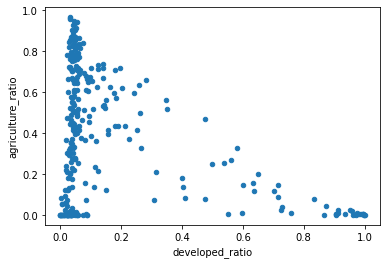

In [12]:
#q2: What is the relationship between developed_ratio and _____? [PLOT]
train.plot.scatter(x = 'developed_ratio', y = 'agriculture_ratio')

In [25]:
#q3: What are the developed_ratio predictions of a Linear model on the first 5 test points?
lr=LinearRegression()
df_prediction=test.copy()
feature= ['lat','lon','water_ratio','forest_ratio','agriculture_ratio'] #list in bracekt so it remians as a dataframe
d_ratio='developed_ratio'
lr.fit(train[feature],train[d_ratio])
df_prediction['predicted']=lr.predict(test[feature])
df_prediction.head()

,file_name,district_name,lon,lat,water_ratio,forest_ratio,agriculture_ratio,developed_ratio,predicted
132,area0132.npy,district 06,-87.940213,43.750300,0.0058,0.0266,0.5506,0.2990,0.187514
309,area0309.npy,district 07,-91.854009,45.352143,0.0002,0.1366,0.8074,0.0401,-0.155128
341,area0341.npy,district 01,-88.294035,42.656175,0.0010,0.3283,0.2029,0.1805,0.376093
196,area0196.npy,district 06,-89.557249,44.187877,0.0000,0.0836,0.8079,0.0412,-0.054414
246,area0246.npy,district 05,-88.596203,43.159942,0.0002,0.0201,0.6677,0.0921,0.188176


In [45]:
#q4: How does the model score when evaluated against the test dataset?
lr.score(test[feature],test['developed_ratio'])


0.7138077753811825

<AxesSubplot:xlabel='developed_ratio', ylabel='predicted'>

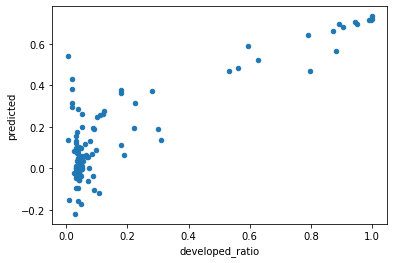

In [46]:
#q5: How do the predictions compare to the actual values? [PLOT]
df_prediction.plot.scatter(x = 'developed_ratio', y = 'predicted')

[-0.11061346 -0.02894837 -0.70219215 -0.72965589 -0.78825866]


<AxesSubplot:>

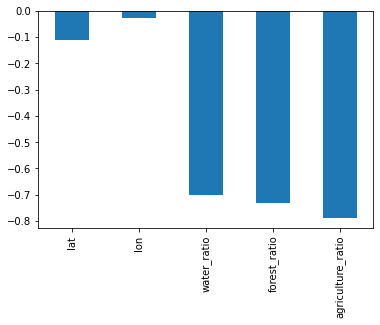

In [52]:
#q6: What are the coefficients for each feature in your model? [PLOT]
c=lr.coef_
print (c)
pd.Series(c,index = feature).plot.bar()

In [54]:
 #q7:Can we beat our simple model's score of 0.756 with a more complicated model?
complex_model = Pipeline([('both',make_column_transformer((OneHotEncoder(),['district_name']),(PolynomialFeatures(degree = 2,include_bias=False),
                                                                                                ['water_ratio','forest_ratio','agriculture_ratio']),
                                    remainder = "passthrough")),
    ('lr', LinearRegression())])
complex_model.fit(train[['district_name','lat','lon','water_ratio','forest_ratio','agriculture_ratio']],
                   train['developed_ratio'])
complex_model.score(test[['district_name','lat','lon','water_ratio','forest_ratio','agriculture_ratio']],
                     test['developed_ratio'])
    
#Yes by doing this we can make it better 

0.8420970788505493

Part 2: Cross Validation

In [60]:
#Q8: what are the mean (average) scores for simple and complex models, respectively?
simple_score = cross_val_score(
    lr,
    train[['lat','lon','water_ratio','forest_ratio','agriculture_ratio']],
    train['developed_ratio'],
    cv = 8)

complex_score = cross_val_score(
    complex_model,
    train[['district_name','lat','lon','water_ratio','forest_ratio','agriculture_ratio']],
    train['developed_ratio'],
    cv = 8)
print (simple_score.mean(),complex_score.mean())

(simple_score.mean(),complex_score.mean())


0.6517545836308132 0.7882683505969756


(0.6517545836308132, 0.7882683505969756)

In [59]:
#q9: what is the standard deviation of scores for each model?
(np.std(simple_score),np.std(complex_score))

(0.11307460959365212, 0.06667525211477948)

Part 3: Computing Feature Metrics


In [62]:
connection = sqlite3.connect("data/images.db")
df2 = pd.read_sql("""
SELECT file_name, district_name, lon, lat, water_ratio, forest_ratio, agriculture_ratio, developed_ratio
FROM sample
INNER JOIN districts ON sample.district_id = districts.district_id
""", connection)
df2

,file_name,district_name,lon,lat,water_ratio,forest_ratio,agriculture_ratio,developed_ratio
0,area0000.npy,district 03,-91.094093,43.750081,0.0000,0.6065,0.3520,0.0371
1,area0001.npy,district 06,-88.441833,44.206438,0.1914,0.0005,0.0040,0.7953
2,area0002.npy,district 07,-90.757041,45.801727,0.0140,0.6794,0.0000,0.0000
3,area0003.npy,district 08,-88.234996,44.788954,0.0002,0.1254,0.5502,0.0390
4,area0004.npy,district 04,-87.954035,43.078655,0.0000,0.0014,0.0030,0.9948
...,...,...,...,...,...,...,...,...
1995,area1995.npy,district 01,-88.960584,42.591088,NaN,NaN,NaN,NaN
1996,area1996.npy,district 01,-88.530275,42.714524,NaN,NaN,NaN,NaN
1997,area1997.npy,district 07,-89.828437,45.408001,NaN,NaN,NaN,NaN
1998,area1998.npy,district 03,-91.276886,43.994077,NaN,NaN,NaN,NaN


In [94]:
def encode_ratio_value(array):
    #"water" as code 11, "forest" as codes 41-43, "agriculture" as codes 81-82, and "developed" as codes 21-24
    water_ratio=[11]
    forest_ratio=[41,42,43]
    agriculture_ratio=[81,82]
    developed_ratio=[21,22,23,24]
    arr=array.reshape(-1,1) #vertical column dimension
    #using isin to get a boolean matrix; .sum() gives a number for all True result, and thus the ratio
    return (np.isin(arr,water_ratio).sum()/len(arr),
            np.isin(arr,forest_ratio).sum()/len(arr),
            np.isin(arr,agriculture_ratio).sum()/len(arr),
            np.isin(arr,developed_ratio).sum()/len(arr))     


In [96]:
#missing value starts at row 400

for i in range(400,2000):
    file_name=df2.loc[i,:][0]
    with ZipFile('data/images.zip') as zf:
        with zf.open(file_name) as f:
            buf = io.BytesIO(f.read())
            map_array = np.load(buf)
            df2.iloc[i,4:] = encode_ratio_value(map_array)        #all the features are missing, startingfrom col 4

In [97]:
#Q10: How many cells in all of area1234.npy contain code 52?
with ZipFile('data/images.zip') as zf:
    with zf.open('area1234.npy') as f:
        buf = io.BytesIO(f.read())
        map_array = np.load(buf)
np.isin(map_array.reshape(-1,1),52).sum()

80

In [103]:
#Q11: What are the last 5 rows of the new test dataset?
train2, test2 = train_test_split(df2, random_state=0)
test2.tail()

,file_name,district_name,lon,lat,water_ratio,forest_ratio,agriculture_ratio,developed_ratio
936,area0936.npy,district 03,-92.152574,44.502114,0.0000,0.4248,0.5276,0.0396
1524,area1524.npy,district 02,-90.151901,43.211515,0.0002,0.1870,0.7766,0.0344
1415,area1415.npy,district 05,-88.921017,43.197963,0.0001,0.0543,0.6463,0.0305
1223,area1223.npy,district 04,-87.906383,43.074510,0.0145,0.0169,0.0060,0.9189
1548,area1548.npy,district 03,-90.359220,43.570773,0.0000,0.2854,0.6702,0.0395


In [106]:
train2


,file_name,district_name,lon,lat,water_ratio,forest_ratio,agriculture_ratio,developed_ratio
1045,area1045.npy,district 04,-87.987848,43.109481,0.0010,0.0073,0.0041,0.9771
937,area0937.npy,district 05,-88.647044,43.310665,0.0001,0.0532,0.8389,0.0559
1658,area1658.npy,district 04,-87.970109,43.191382,0.0433,0.0742,0.0580,0.6605
529,area0529.npy,district 02,-90.131632,42.910160,0.0000,0.0819,0.8087,0.0981
895,area0895.npy,district 01,-88.329272,42.658921,0.0014,0.0960,0.6284,0.0521
...,...,...,...,...,...,...,...,...
835,area0835.npy,district 05,-88.193178,43.179645,0.0006,0.1344,0.4339,0.1502
1216,area1216.npy,district 05,-88.637597,43.045962,0.0007,0.0634,0.6788,0.0437
1653,area1653.npy,district 05,-88.170471,43.015347,0.0143,0.1511,0.1095,0.5175
559,area0559.npy,district 08,-88.116382,44.041477,0.0027,0.0185,0.6862,0.0350


In [107]:
#Q12: what are the mean (average) scores for simple and complex models, respectively, on the larger dataset?


simple_score2 = cross_val_score(
    lr,
    train2[['lat','lon','water_ratio','forest_ratio','agriculture_ratio']],
    train2['developed_ratio'],
    cv = 8)

complex_score2 = cross_val_score(
    complex_model,
    train2[['district_name','lat','lon','water_ratio','forest_ratio','agriculture_ratio']],
    train2['developed_ratio'],
    cv = 8)
#print (simple_score.mean(),complex_score.mean())

(simple_score2.mean(),complex_score2.mean())

(0.7729881088121584, 0.8842058969526818)

In [6]:
#map annotation 


with ZipFile("data/madison.zip") as zf:
    with zf.open("year-2001.npy") as f:
        buf = io.BytesIO(f.read())
        madison_01 = np.load(buf)
    with zf.open("year-2016.npy") as f:
        buf = io.BytesIO(f.read())
        madison_16 = np.load(buf)

In [159]:
#Q13: What is the shape of the 2001 Madison matrix?
madison_01.shape

(1200, 1200)

In [126]:
#Q14: What portion of the points in Madison changed from 2001 to 2016?

madison_16.shape

diff_ratio=((madison_16 !=madison_01).sum())/(1200*1200)
diff_ratio

0.06156458333333333

In [27]:
#Q15: What years appear in madison.zip
l = []
with ZipFile("data/madison.zip") as zf:
    file_list = zf.namelist()
    for name in file_list:
        l.append(name)
l=str(l)
num_str =re.findall('[0-9]+', l)
num_int=[]
for i in num_str:
    num_int.append(int(i))
num_int

[2001, 2004, 2006, 2008, 2011, 2013, 2016]

In [5]:
#Q16: How has Madison evolved over the years? [VIDEO]

from matplotlib.colors import ListedColormap

def get_usage_colormap():
    use_cmap = np.zeros(shape=(256,4))
    use_cmap[:,-1] = 1
    uses = np.array([
        [0, 0.00000000000, 0.00000000000, 0.00000000000],
        [11, 0.27843137255, 0.41960784314, 0.62745098039],
        [12, 0.81960784314, 0.86666666667, 0.97647058824],
        [21, 0.86666666667, 0.78823529412, 0.78823529412],
        [22, 0.84705882353, 0.57647058824, 0.50980392157],
        [23, 0.92941176471, 0.00000000000, 0.00000000000],
        [24, 0.66666666667, 0.00000000000, 0.00000000000],
        [31, 0.69803921569, 0.67843137255, 0.63921568628],
        [41, 0.40784313726, 0.66666666667, 0.38823529412],
        [42, 0.10980392157, 0.38823529412, 0.18823529412],
        [43, 0.70980392157, 0.78823529412, 0.55686274510],
        [51, 0.64705882353, 0.54901960784, 0.18823529412],
        [52, 0.80000000000, 0.72941176471, 0.48627450980],
        [71, 0.88627450980, 0.88627450980, 0.75686274510],
        [72, 0.78823529412, 0.78823529412, 0.46666666667],
        [73, 0.60000000000, 0.75686274510, 0.27843137255],
        [74, 0.46666666667, 0.67843137255, 0.57647058824],
        [81, 0.85882352941, 0.84705882353, 0.23921568628],
        [82, 0.66666666667, 0.43921568628, 0.15686274510],
        [90, 0.72941176471, 0.84705882353, 0.91764705882],
        [95, 0.43921568628, 0.63921568628, 0.72941176471],
    ])
    for row in uses:
        use_cmap[int(row[0]),:-1] = row[1:]
    return ListedColormap(use_cmap)




In [32]:
#q16: How has Madison evolved over the years? [VIDEO]
def draw(frame):
    axes.cla()
    with ZipFile("data/madison.zip") as zf:
        l = zf.namelist()
        file_name = l[frame]
        #print (file_name[0:9])
        with zf.open(file_name) as f:
            buf = io.BytesIO(f.read())
            madison = np.load(buf)
    axes.imshow(madison, vmin=0, vmax=255,cmap = get_usage_colormap())
    
    axes.set_title(file_name[:9])

###
fig, axes = plt.subplots()
fa = FuncAnimation(fig, draw, frames = 7,interval=1000)
vid = fa.to_html5_video()
plt.close()
HTML(vid)